In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class IsingModel2D:
    def __init__(self, grid_width):
        self.l = grid_width
        self.spins = (np.random.uniform(size=[self.l, self.l]) < 0.5)*2 - 1
        self.dims = 2*np.ones_like(self.spins, dtype=int)
        self.T = 1.0
        
    def get_state(self):
        return (self.spins > 0).astype(int)
    
    def set_state(self, state):
        self.spins = 2*state-1
        
    def get_log_prob(self):
        l = self.l
        energy = 0.0
        energy += np.sum(self.spins[:,:l-1]*self.spins[:,1:])
        energy += np.sum(self.spins[:l-1,:]*self.spins[1:,:])
        return -energy/self.T
        
    def get_cond_prob(self):
        l = self.l
        cond_energy = np.zeros_like(self.spins)
        cond_energy[:,:l-1] += self.spins[:,1:]
        cond_energy[:,1:] += self.spins[:,:l-1]
        cond_energy[:l-1,:] += self.spins[1:,:]
        cond_energy[1:,:] += self.spins[:l-1,:]
        cond_log_prob = -cond_energy/self.T - np.logaddexp(cond_energy/self.T,-cond_energy/self.T)
        cond_prob = np.exp(cond_log_prob)
        cond_prob = cond_prob*(self.spins > 0) + (1-cond_prob)*(self.spins < 0)
        return cond_prob

In [3]:
class DGibbs:
    def __init__(self, distribution, different_velocities=True):
        assert hasattr(distribution, 'get_log_prob')
        assert hasattr(distribution, 'get_state')
        assert hasattr(distribution, 'set_state')
        assert hasattr(distribution, 'dims')
        assert hasattr(distribution, 'get_cond_prob')
        self.dist = distribution
        self.dims = self.dist.dims.flatten()
        self.state = self.dist.get_state().copy().flatten()
        self.x = self.state.copy()
        if different_velocities:
            self.v = 1000./np.arange(1000, 1000+self.state.size)
        else:
            self.v = np.ones_like(self.state)
        self.v = self.v/self.dist.get_cond_prob().flatten()
        self.dist_to_border = np.ones_like(self.v)
        self.samples = []
        self.weights = []
        self.trajectory = [self.state.copy()]
        
    def iterate(self):
        # evaluate time
        time_until_border = self.dist_to_border/self.v
        iterate_time = np.min(time_until_border)
        change_dim = np.argmin(time_until_border)
        # update coordinates
        self.x = (self.x + self.v*iterate_time) % self.dims
        self.state[change_dim] = (self.state[change_dim]+1) % self.dims[change_dim]
        self.dist_to_border = self.dist_to_border - self.v*iterate_time
        self.dist_to_border[change_dim] = 1.0
        # put into samples
        self.samples.append(self.state.copy())
        self.weights.append(iterate_time)
        self.trajectory.append(self.x.copy())
        # update state
        self.dist.set_state(self.state.reshape(self.dist.dims.shape).copy())
        self.v = 1.0/self.dist.get_cond_prob().flatten()
        
class Gibbs:
    def __init__(self, distribution):
        assert hasattr(distribution, 'get_log_prob')
        assert hasattr(distribution, 'get_state')
        assert hasattr(distribution, 'set_state')
        assert hasattr(distribution, 'dims')
        assert hasattr(distribution, 'get_cond_prob')
        self.dist = distribution
        self.dims = self.dist.dims.flatten()
        self.state = self.dist.get_state().copy().flatten()
        self.samples = []
        self.weights = []
        self.change_dim = 0
        
    def iterate(self):
        cond_prob = self.dist.get_cond_prob().flatten()
        # update coordinates
        u = numpy.random.uniform()
        if u > cond_prob[self.change_dim]:
            self.state[self.change_dim] = (self.state[self.change_dim]+1) % self.dims[self.change_dim]
        # put into samples
        self.samples.append(self.state.copy())
        self.weights.append(1.0)
        # update state
        self.dist.set_state(self.state.reshape(self.dist.dims.shape).copy())
        self.change_dim = (self.change_dim + 1) % self.state.size

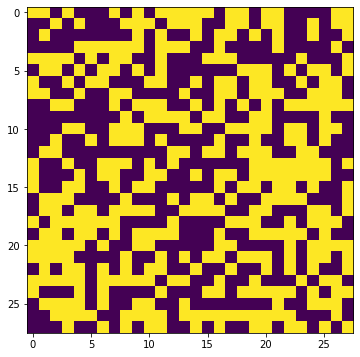

In [28]:
ising_model_d = IsingModel2D(28)
ising_model_s = IsingModel2D(28)
ising_model = IsingModel2D(28)
ising_model.spins = ising_model_d.spins.copy()
ising_model_s.spins = ising_model_d.spins.copy()
d_gibbs_sampler = DGibbs(ising_model_d)
suzuki_sampler = DGibbs(ising_model_s, different_velocities=False)
gibbs_sampler = Gibbs(ising_model)
plt.imshow(ising_model.get_state())

In [29]:
n_iter = 20000
probs_d = np.zeros(n_iter)
probs_s = np.zeros(n_iter)
probs = np.zeros(n_iter)
for i in range(n_iter):
    probs_d[i] = d_gibbs_sampler.dist.get_log_prob()
    d_gibbs_sampler.iterate()
    probs_s[i] = suzuki_sampler.dist.get_log_prob()
    suzuki_sampler.iterate()
    probs[i] = gibbs_sampler.dist.get_log_prob()
    gibbs_sampler.iterate()

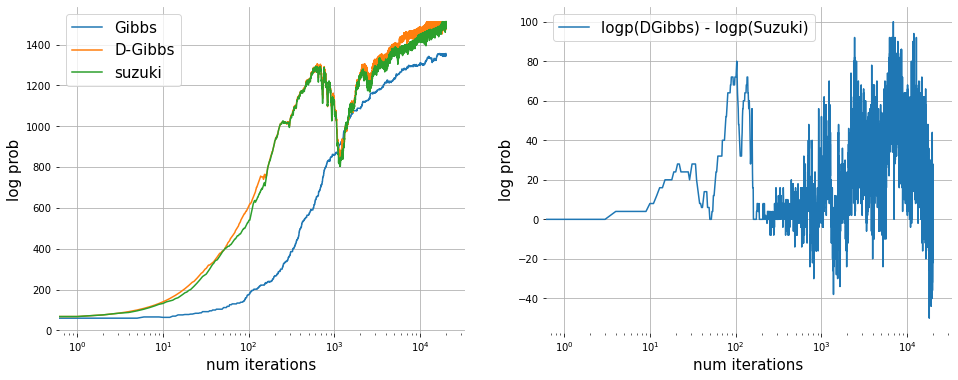

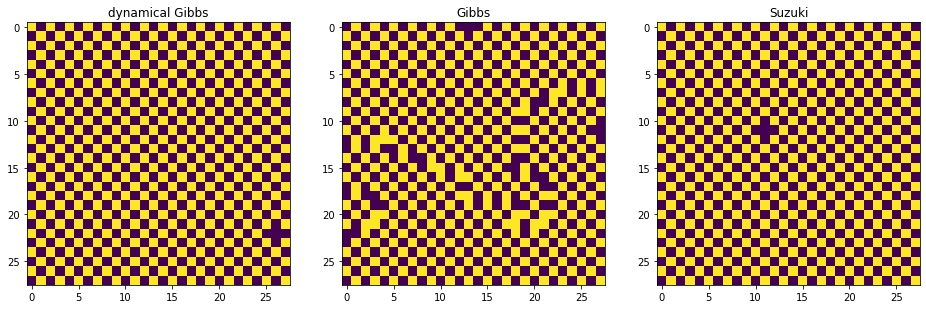

In [30]:
figsize(16,6)
plt.subplot(121)
plt.plot(probs, label='Gibbs')
plt.plot(probs_d, label='D-Gibbs')
plt.plot(probs_s, label='suzuki')
plt.ylabel('log prob', fontsize=15)
plt.xlabel('num iterations', fontsize=15)
plt.xscale('log')
plt.box(False)
plt.legend(fontsize=15)
plt.grid()
plt.subplot(122)
plt.plot(probs_d-probs_s, label='logp(DGibbs) - logp(Suzuki)')
plt.ylabel('log prob', fontsize=15)
plt.xlabel('num iterations', fontsize=15)
plt.xscale('log')
plt.box(False)
plt.legend(fontsize=15)
plt.grid()
plt.show()

plt.subplot(131)
plt.imshow(d_gibbs_sampler.dist.get_state())
plt.title('dynamical Gibbs')
plt.subplot(132)
plt.imshow(gibbs_sampler.dist.get_state())
plt.title('Gibbs')
plt.subplot(133)
plt.imshow(suzuki_sampler.dist.get_state())
plt.title('Suzuki')
plt.show()